In [5]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import pandas as pd
import plotly.graph_objects as go

In [6]:
df = pd.read_excel('excels/OSA_DB_UPM_Vowels_Recordings.xlsx')

In [7]:
import librosa


audio_directory = '../../DATOS/DL/SPEECH_VOWELS'

# Process the wav files in df['wav_file'] to get the duration and sample rate
def get_duration_sample_rate(file, audio_directory=audio_directory):
    y, sr = librosa.load(audio_directory + '/' + file)
    duration = librosa.get_duration(y=y, sr=sr)
    return duration, sr

# df['duration'], df['sample_rate'] = zip(*df['wav_file'].map(get_duration_sample_rate))

In [8]:
def load_audio_segment(wav_file, audio_directory, duration_sec=1.0, target_sr=None):
    """
    Loads the first duration_sec seconds of an audio file
    """
    path = os.path.join(audio_directory, wav_file)
    y, sr = librosa.load(path, sr=target_sr)
    samples = int(sr * duration_sec)
    return y[:samples], sr



In [9]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

audio_directory = '../../DATOS/DL/SPEECH_VOWELS'

def load_audio_segment(wav_file, audio_directory, duration_sec=1.0, target_sr=None):
    path = os.path.join(audio_directory, wav_file)
    y, sr = librosa.load(path, sr=target_sr)
    samples = int(sr * duration_sec)
    return y[:samples], sr

def compute_rms_metrics(wav_file, audio_directory):
    y, sr = load_audio_segment(wav_file, audio_directory, duration_sec=1.0)
    
    # Short-time RMS energy
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    
    mean_rms = np.mean(rms)
    median_rms = np.median(rms)
    min_rms = np.min(rms)
    
    return mean_rms, median_rms, min_rms

mean_rms_values = []
median_rms_values = []
min_rms_values = []

for file in df['wav_file']:
    mean_rms, median_rms, min_rms = compute_rms_metrics(file, audio_directory)
    mean_rms_values.append(mean_rms)
    median_rms_values.append(median_rms)
    min_rms_values.append(min_rms)

mean_rms_values = np.array(mean_rms_values)
median_rms_values = np.array(median_rms_values)
min_rms_values = np.array(min_rms_values)


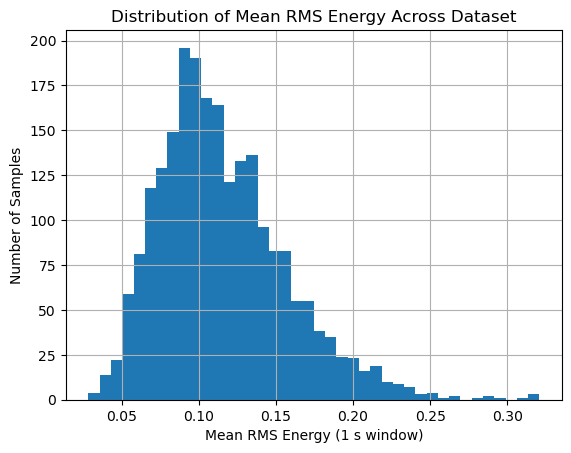

In [15]:
plt.figure()
plt.hist(mean_rms_values, bins=40)
plt.xlabel('Mean RMS Energy (1 s window)')
plt.ylabel('Number of Samples')
plt.title('Distribution of Mean RMS Energy Across Dataset')
plt.grid(True)
plt.show()


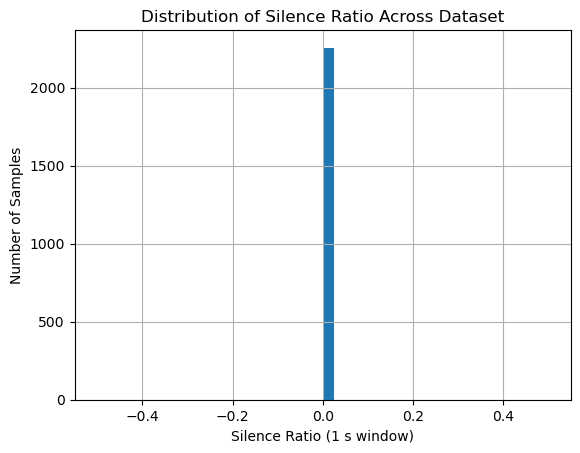

In [16]:
def compute_silence_ratio(wav_file, audio_directory, threshold=0.01):
    y, sr = load_audio_segment(wav_file, audio_directory, duration_sec=1.0)
    rms = librosa.feature.rms(y=y)[0]
    silence_ratio = np.mean(rms < threshold)
    return silence_ratio

silence_ratios = [compute_silence_ratio(f, audio_directory) for f in df['wav_file']]

plt.figure()
plt.hist(silence_ratios, bins=40)
plt.xlabel('Silence Ratio (1 s window)')
plt.ylabel('Number of Samples')
plt.title('Distribution of Silence Ratio Across Dataset')
plt.grid(True)
plt.show()


In [10]:
def plot_vowel_waveforms(
    df,
    patient_index,
    audio_directory,
    duration_sec=0.1
):
    """
    Plots waveform (first duration_sec seconds) in separate figures for each vowel
    """
    patient_id = df.loc[patient_index, 'Patient']
    patient_df = df[df['Patient'] == patient_id]

    vowels = ['a', 'e', 'i', 'o', 'u']

    for vowel in vowels:
        row = patient_df[patient_df['vowel'] == vowel].iloc[0]
        y, sr = load_audio_segment(row['wav_file'], audio_directory, duration_sec)

        time = np.linspace(0, duration_sec, len(y))

        plt.figure(figsize=(10, 3))
        plt.plot(time, y)
        plt.title(f"Patient {patient_id} – Vowel '{vowel}' ({duration_sec:.3f} s)")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()



In [11]:
def plot_vowel_spectrograms(
    df,
    patient_index,
    audio_directory,
    duration_sec=1.0,
    target_sr=8000,
    n_fft=512,
    hop_length=128,   # 75% overlap
    window='hann',
    cmap='magma'
):
    """
    Plots vowel spectrograms optimized for formant visualization:
    - Audio resampled to 8 kHz
    - High overlap STFT
    - Frequency range implicitly 0–4 kHz
    """

    patient_id = df.loc[patient_index, 'Patient']
    patient_df = df[df['Patient'] == patient_id]

    vowels = ['a', 'e', 'i', 'o', 'u']

    for vowel in vowels:
        row = patient_df[patient_df['vowel'] == vowel].iloc[0]

        # Load audio segment (native sr)
        y, sr = load_audio_segment(
            row['wav_file'],
            audio_directory,
            duration_sec
        )

        # Resample to 8 kHz
        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            sr = target_sr

        # STFT with overlapping windows
        S = librosa.stft(
            y,
            n_fft=n_fft,
            hop_length=hop_length,
            window=window
        )

        S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(
            S_db,
            sr=sr,
            hop_length=hop_length,
            x_axis='time',
            y_axis='hz',
            cmap=cmap
        )
        plt.colorbar(format="%+2.0f dB")

        plt.title(
            f"Patient {patient_id} – Vowel '{vowel}'\n"
            f"Resampled to 8 kHz | n_fft={n_fft}, hop={hop_length}"
        )

        plt.tight_layout()
        plt.show()


In [12]:
def listen_to_vowels(
    df,
    patient_index,
    audio_directory,
    duration_sec=1.0
):
    """
    Plays first duration_sec seconds for each vowel
    """
    patient_id = df.loc[patient_index, 'Patient']
    patient_df = df[df['Patient'] == patient_id]

    vowels = ['a', 'e', 'i', 'o', 'u']

    for vowel in vowels:
        row = patient_df[patient_df['vowel'] == vowel].iloc[0]
        y, sr = load_audio_segment(row['wav_file'], audio_directory, duration_sec)

        print(f"Patient {patient_id} – Vowel '{vowel}' ({duration_sec:.2f}s)")
        display(Audio(y, rate=sr))



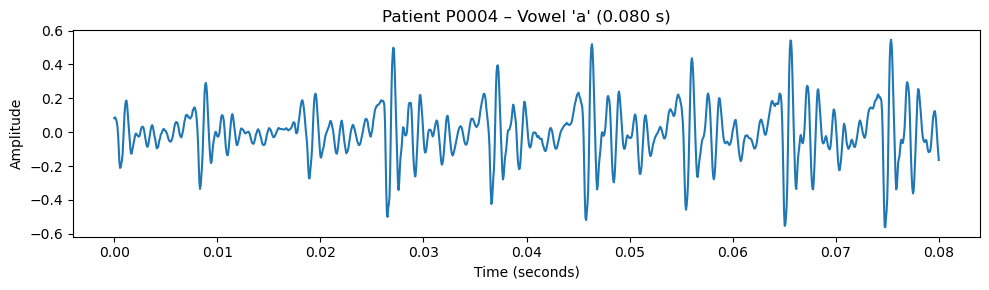

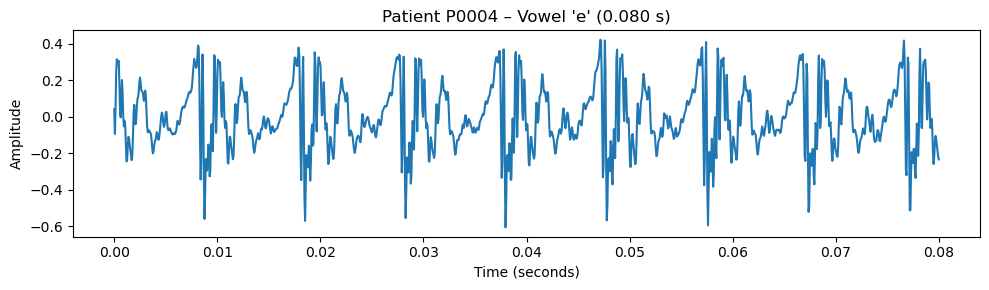

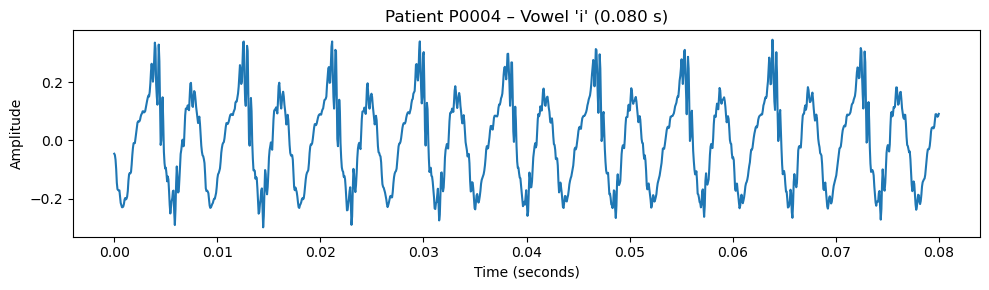

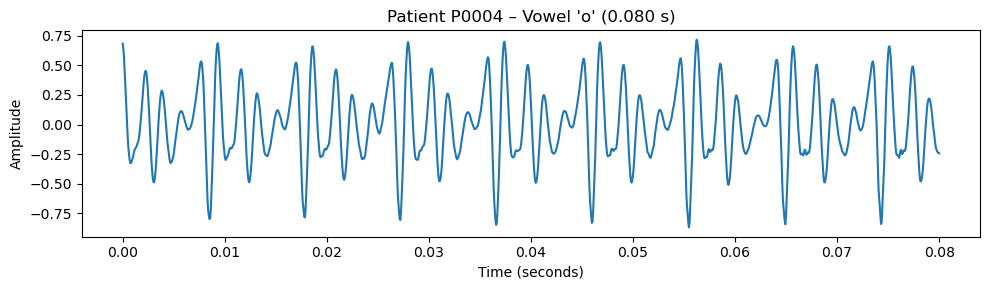

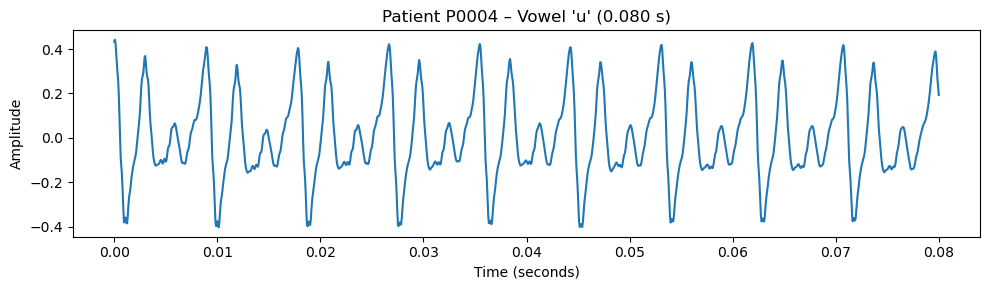

Patient P0004 – Vowel 'a' (1.00s)


Patient P0004 – Vowel 'e' (1.00s)


Patient P0004 – Vowel 'i' (1.00s)


Patient P0004 – Vowel 'o' (1.00s)


Patient P0004 – Vowel 'u' (1.00s)


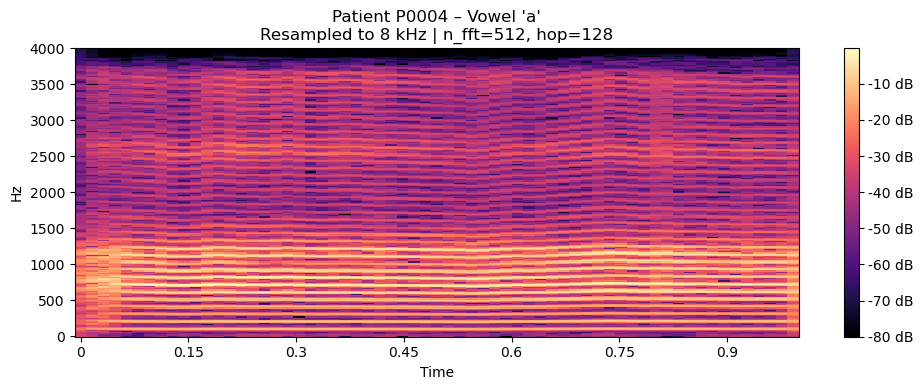

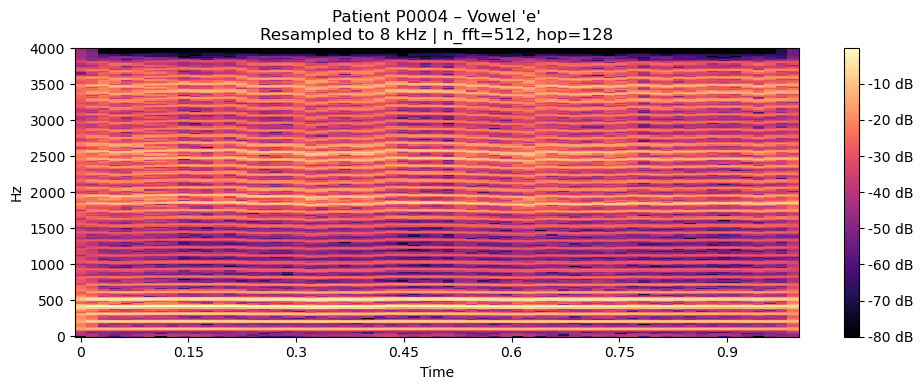

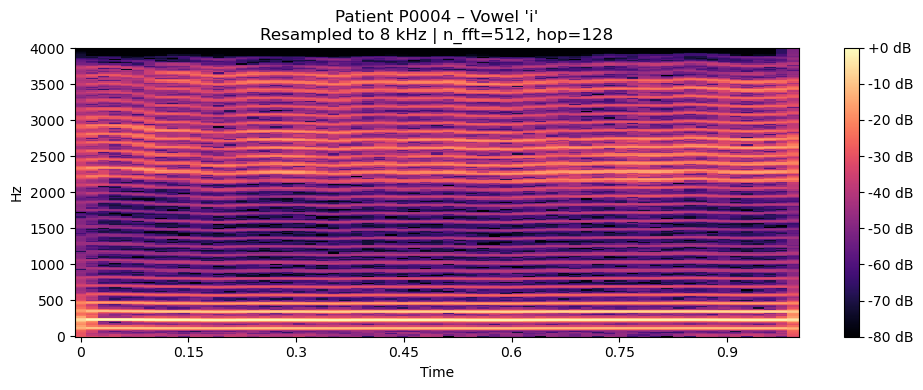

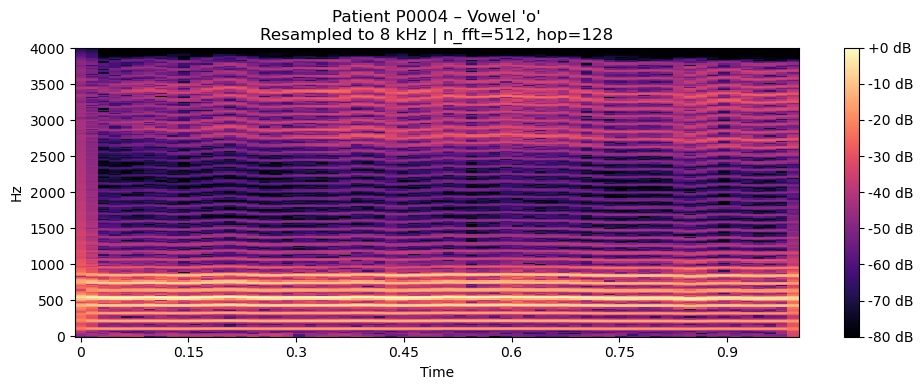

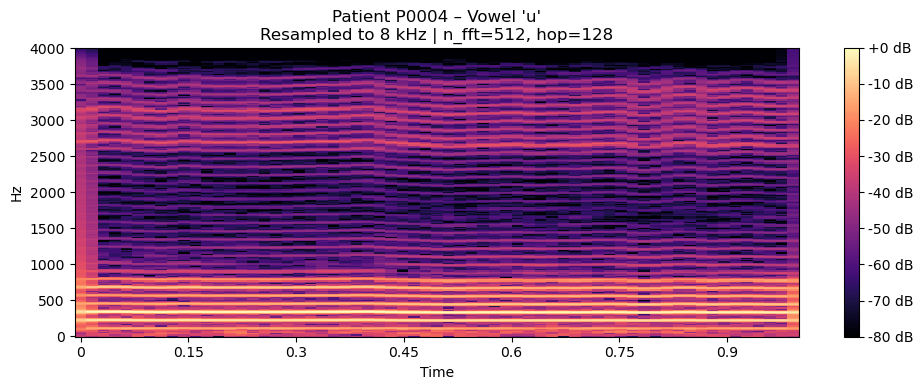

In [13]:

i = 0  # index of the patient in df

plot_vowel_waveforms(df, i, audio_directory, duration_sec=0.08)

listen_to_vowels(df, i, audio_directory, duration_sec=1)


plot_vowel_spectrograms(
    df,
    i,
    audio_directory,
    duration_sec=1.0,
    target_sr=8000,
    n_fft=512,
    hop_length=128,   # 75% overlap
    window='hann',
    cmap='magma'
)


In [14]:
from scipy.signal import welch
import plotly.graph_objects as go
import os
import numpy as np
import librosa

def plot_vowel_spectra_separate(
    df,
    patient_index,
    audio_directory,
    duration_sec=1.0,
    fs_target=16000,
    nperseg=int(1024/2),
    noverlap=int(768/2),
    nfft=4096
):
    patient_id = df.loc[patient_index, 'Patient']
    patient_df = df[df['Patient'] == patient_id]

    vowels = ['a', 'e', 'i', 'o', 'u']

    for vowel in vowels:
        row = patient_df[patient_df['vowel'] == vowel].iloc[0]

        # ----- Load & resample -----
        wav_path = os.path.join(audio_directory, row['wav_file'])
        wav, fs = librosa.load(wav_path, sr=None)
        wav = librosa.resample(wav, orig_sr=fs, target_sr=fs_target)
        wav = wav[: int(fs_target * duration_sec)]

        # ----- Pre-emphasis (same as your pipeline) -----
        gamma = 0.7
        wav = np.append(wav[0], wav[1:] - gamma * wav[:-1])

        # ----- Welch PSD -----
        freqs, Pxx = welch(
            wav,
            fs=fs_target,
            window='hann',
            nperseg=nperseg,
            noverlap=noverlap,
            nfft=nfft,
            scaling='density'
        )

        Pxx_db = 10 * np.log10(Pxx + 1e-12)

        # ----- Plot -----
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=freqs,
            y=Pxx_db,
            mode='lines',
            line=dict(width=3),
            name=f"Vowel '{vowel}'"
        ))

        fig.update_layout(
            title=f"Patient {patient_id} – Vowel '{vowel}' | Wideband Spectrum (Welch)",
            xaxis_title="Frequency (Hz)",
            yaxis_title="Power Spectral Density (dB/Hz)",
            xaxis=dict(range=[0, 4000]),
            width=1400,
            height=600,
            plot_bgcolor='white'
        )

        fig.update_yaxes(autorange=True)
        fig.show()

